In this post, we will try the ResNet for image recognition. We will learn the Keras application tutorial for ResNet engineering from scratch. (Residual networks) is a deep neural network that is used as a backbone for many computer vision applications such as object detection, image segmentation, etc.


Distinguished by the ResNet syntax, a "shortcut" or "skip connection" allows for the gradient to be re-propagated directly to previous layers

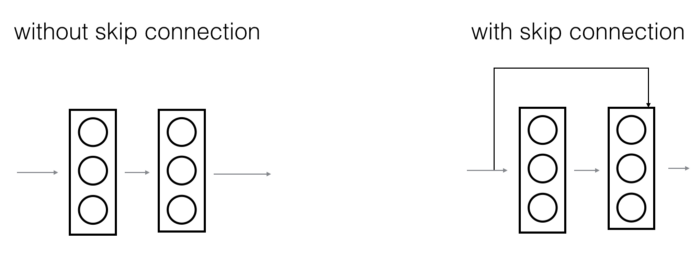




In [41]:
# import libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline




#  Load data

In [42]:
# Load data using pandas.read_csv()

data = pd.read_csv('../input/digit-recognizer/train.csv')
labels = data.pop('label').to_numpy()
data = data.to_numpy().reshape(-1,28,28)

# Add dimension

data = np.expand_dims(data,axis=-1)
labels = np.expand_dims(labels,axis=-1)

# Fill the image with zeros around it

data = tf.pad(data,[[0,0],[2,2],[2,2],[0,0]])

num = data.shape[0] // 10
train_data, val_data, test_data = tf.split(data,[num*8, num, num])
train_label, val_label, test_label = tf.split(labels,[num*8, num, num])

train_ds = tf.data.Dataset.from_tensor_slices((train_data,train_label)).shuffle(33600,seed=42).batch(128)
val_ds = tf.data.Dataset.from_tensor_slices((val_data,val_label)).shuffle(33600,seed=42).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((test_data,test_label)).shuffle(33600,seed=42).batch(128)
# The shape of the picture

image_shape = (32,32,1)

In [43]:


import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

# Identity Block

Identity block is the standard block used corresponding to the case where the input activation has the same dimensions as the output activation.

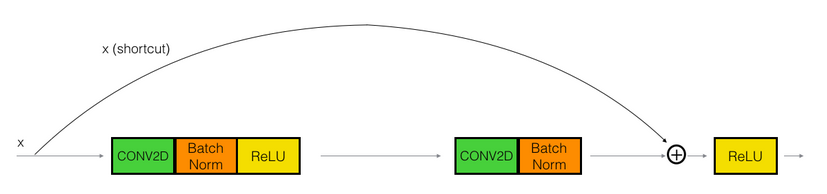

In [50]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

# Convolutional Block
We can use this type of block when the input and output dimensions don’t match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path.

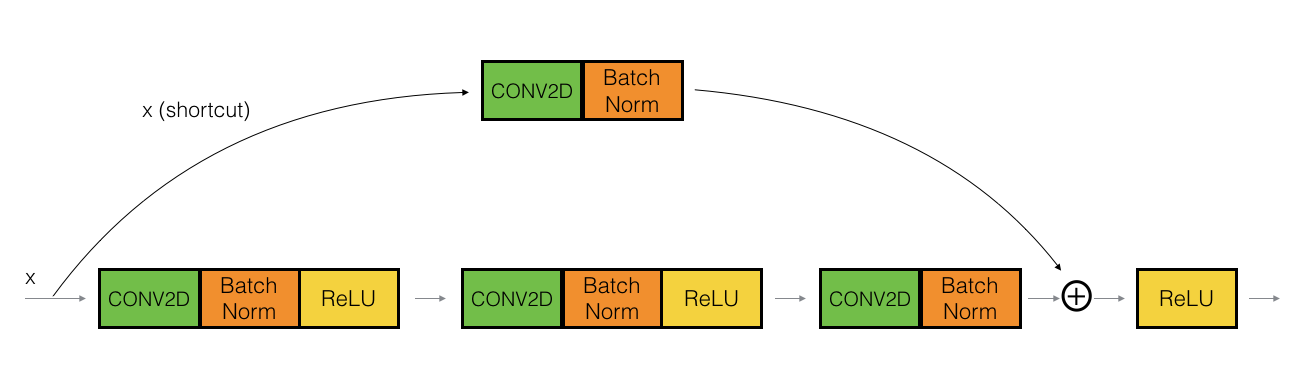

In [51]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

# bulid ResNet model 

In [52]:

def ResNet(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

base_model = ResNet(input_shape=image_shape)
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(400, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(300, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 10,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)
model = Model(inputs=base_model.input, outputs=headModel)
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 38, 38, 1)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   3200        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

# train modle

In [53]:

from keras.callbacks import ModelCheckpoint
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
checkpointer_best_train = ModelCheckpoint(
    filepath='./final_model3.h5',
    monitor='loss', verbose=1, save_best_only=True, mode='min'
)

callback_list = [checkpointer_best_train]

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',
                                    patience=10,restore_best_weights=True)

# Using ReduceLROnPlateau, the learning rate is reduced by half when val_accuracy is not improved for 5 consecutive times
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5,patience=5)

# training
history = model.fit(train_ds,batch_size=64 ,epochs=110,validation_data=val_ds,
                    callbacks=callback_list)

Epoch 1/110
263/263 [==============================] - 20s 54ms/step - loss: 1.6626 - accuracy: 0.4382 - val_loss: 1.1626 - val_accuracy: 0.7150

Epoch 00001: loss improved from inf to 1.07403, saving model to ./final_model3.h5
Epoch 2/110
263/263 [==============================] - 14s 51ms/step - loss: 0.3243 - accuracy: 0.8963 - val_loss: 0.2652 - val_accuracy: 0.9119

Epoch 00002: loss improved from 1.07403 to 0.30459, saving model to ./final_model3.h5
Epoch 3/110
263/263 [==============================] - 14s 52ms/step - loss: 0.1518 - accuracy: 0.9528 - val_loss: 0.2417 - val_accuracy: 0.9288

Epoch 00003: loss improved from 0.30459 to 0.14767, saving model to ./final_model3.h5
Epoch 4/110
263/263 [==============================] - 14s 51ms/step - loss: 0.0839 - accuracy: 0.9730 - val_loss: 0.2375 - val_accuracy: 0.9329

Epoch 00004: loss improved from 0.14767 to 0.08847, saving model to ./final_model3.h5
Epoch 5/110
263/263 [==============================] - 13s 51ms/step - loss:


Epoch 00039: loss did not improve from 0.00664
Epoch 40/110
263/263 [==============================] - 14s 53ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.0967 - val_accuracy: 0.9812

Epoch 00040: loss did not improve from 0.00664
Epoch 41/110
263/263 [==============================] - 14s 52ms/step - loss: 0.0070 - accuracy: 0.9981 - val_loss: 0.0966 - val_accuracy: 0.9802

Epoch 00041: loss did not improve from 0.00664
Epoch 42/110
263/263 [==============================] - 14s 53ms/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.1009 - val_accuracy: 0.9824

Epoch 00042: loss did not improve from 0.00664
Epoch 43/110
263/263 [==============================] - 14s 52ms/step - loss: 0.0048 - accuracy: 0.9985 - val_loss: 0.1004 - val_accuracy: 0.9802

Epoch 00043: loss did not improve from 0.00664
Epoch 44/110
263/263 [==============================] - 14s 52ms/step - loss: 0.0063 - accuracy: 0.9983 - val_loss: 0.0827 - val_accuracy: 0.9829

Epoch 00044: loss did not imp

Epoch 81/110
263/263 [==============================] - 13s 50ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.0823 - val_accuracy: 0.9864

Epoch 00081: loss did not improve from 0.00186
Epoch 82/110
263/263 [==============================] - 14s 51ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.0759 - val_accuracy: 0.9860

Epoch 00082: loss did not improve from 0.00186
Epoch 83/110
263/263 [==============================] - 14s 51ms/step - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.0872 - val_accuracy: 0.9855

Epoch 00083: loss did not improve from 0.00186
Epoch 84/110
263/263 [==============================] - 14s 52ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.0719 - val_accuracy: 0.9893

Epoch 00084: loss did not improve from 0.00186
Epoch 85/110
263/263 [==============================] - 14s 52ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0808 - val_accuracy: 0.9869

Epoch 00085: loss did not improve from 0.00186
Epoch 86/110
263/263 [========

In [ ]:



history = model.fit(train_ds,batch_size=64 ,epochs=2,validation_data=val_ds,
                    )

# accuracy

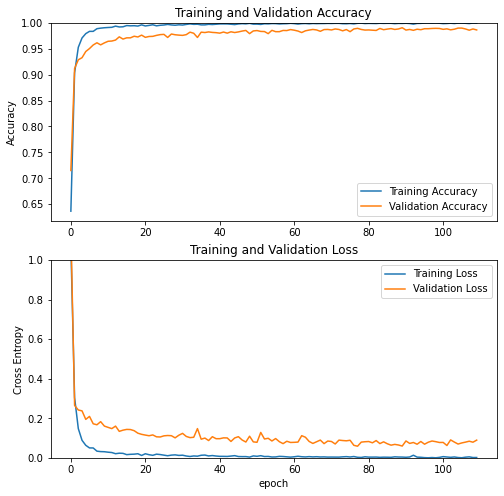

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# accuracy

In [57]:
model.evaluate(test_ds,verbose=2)

33/33 - 1s - loss: 0.0641 - accuracy: 0.9905


[0.0640551820397377, 0.9904761910438538]

# # intialize wights  resume from last train(transfer learning)


In [ ]:
# intialize wights  resume from last train(transfer learning)
'''
from keras.optimizers import Adam

#model_path = '/content/drive/MyDrive/final_model153.h5'
model_path = './final_model3.h5'

model = load_model(model_path)


adam = Adam(lr=0.0001)
model.compile(
    optimizer=adam,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
checkpointer_best_train = ModelCheckpoint(
    filepath='./final_model3.h5',
    monitor='loss', verbose=1, save_best_only=True, mode='min'
)

callback_list = [checkpointer_best_train]

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',
                                    patience=10,restore_best_weights=True)

# Using ReduceLROnPlateau, the learning rate is reduced by half when val_accuracy is not improved for 5 consecutive times
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5,patience=5)


model.summary()
'''

# # load data


In [58]:
# load data

test = pd.read_csv('../input/digit-recognizer/test.csv')
sample_submission = pd.read_csv('../input/digit-recognizer/sample_submission.csv')

In [59]:
# process data

test = test.to_numpy().reshape(-1,28,28)
test = np.expand_dims(test,axis=-1)
test = tf.pad(test,[[0,0],[2,2],[2,2],[0,0]])

test.shape

TensorShape([28000, 32, 32, 1])

In [60]:
sample_submission.shape

(28000, 2)

In [61]:
# predict
result =  model.predict(test)

result.shape

(28000, 10)

In [62]:
# get predict label
predict_label = np.argmax(result,axis=-1)

predict_label.shape

(28000,)

# Show some prediction results

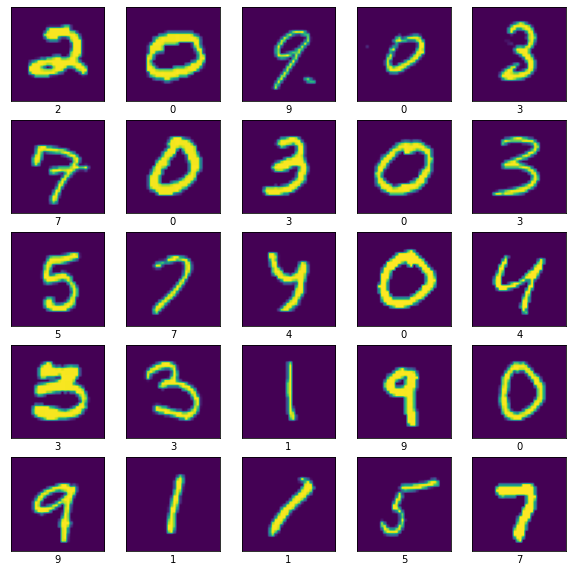

In [63]:
# Show some prediction results

plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(test[i,...,0])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(predict_label[i])

In [64]:
sample_submission['Label'] = predict_label

In [ ]:
sample_submission.to_csv('submission.csv', index=False)